In [1]:
# push!(LOAD_PATH, joinpath(splitdir(pwd())[1], "src"))

In [2]:
# workspace()
# reload("SuperPix")
# using Images
# using SuperPix
# include("/Users/adare/repos/superpix/src/SuperPix.jl")

using Images
using Color
using LightGraphs
using Reactive, Interact

include("grids.jl")
include("means.jl")
include("gradients.jl")
include("io.jl")
include("rag.jl")
include("recombine.jl")
include("slic.jl")
include("vis.jl")

    convert(Type{

Images.Image{Cdest<:Union(Color.AbstractAlphaColorValue{C<:Color.ColorValue{T},T<:Real},Color.ColorValue{T}),N,A<:AbstractArray{T,N}}}, Images.AbstractImageDirect{Csrc<:Union(Color.AbstractAlphaColorValue{C<:Color.ColorValue{T},T<:Real},Color.ColorValue{T}),N}) at /Users/adare/.julia/v0.4/Images/src/core.jl:229
is ambiguous with: 
    convert(Type{Images.Image{T,N,A<:AbstractArray{T,N}}}, Images.Image{T,N,A<:AbstractArray{T,N}}) at /Users/adare/.julia/v0.4/Images/src/core.jl:202.
To fix, define 
    convert(Type{Images.Image{_<:Union(Color.AbstractAlphaColorValue{C<:Color.ColorValue{T},T<:Real},Color.ColorValue{T}),N,A<:AbstractArray{T,N}}}, Images.Image{_<:Union(Color.AbstractAlphaColorValue{C<:Color.ColorValue{T},T<:Real},Color.ColorValue{T}),N,A<:AbstractArray{T,N}})
before the new definition.


segment_overlay (generic function with 1 method)

In [3]:
row_range = 91:380      # Crop input images to this region
col_range = 151:750
k = 1000                # Number of requested superpixels
m = 10                  # Cluster compactness parameter
idx = 100               # Index of image name (e.g. color_1.jpg if idx=1)

100

Lab Images.Image with:
  data: 600x290 Array{Color.Lab{Float32},2}
  properties:
    timedim: 0
    spatialorder:  x y
    pixelspacing:  1.0 1.0

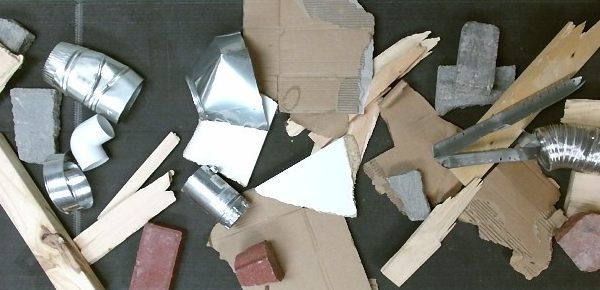

In [4]:
# Read in color image and convert to CIE Lab color space
imlab = lab_image("../input/color_$idx.jpg", row_range, col_range)
show(imlab)
imlab

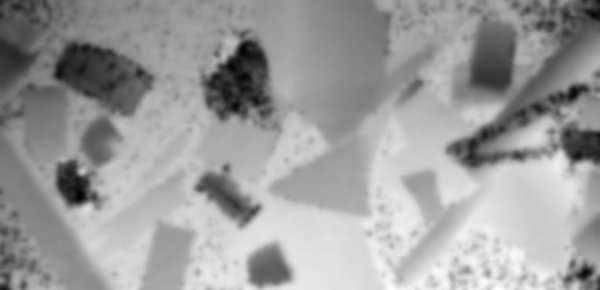

In [5]:
# Read in depth image and preprocess to improve contrast
dep = depth_image("../input/depth_$idx.png", row_range, col_range)
grayim(dep)

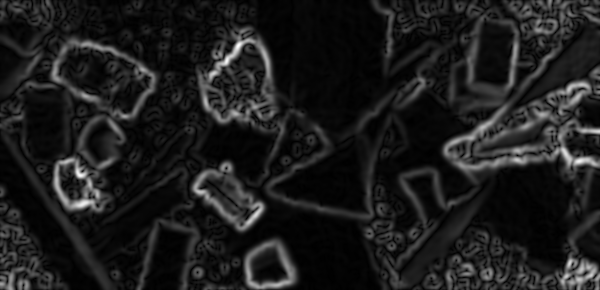

In [6]:
depgrad = depth_image_grad(dep)
grayim(depgrad)

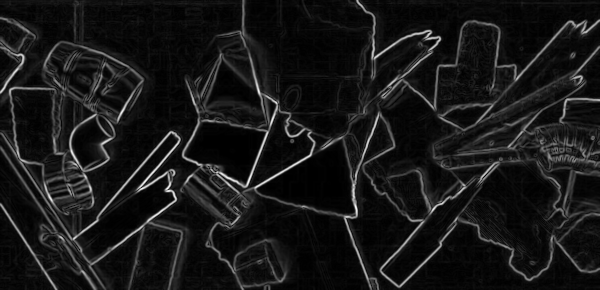

In [7]:
# Compute color image gradient (mean over L,a,b magnitudes)
labgrad = color_image_grad(imlab)
grayim(labgrad)

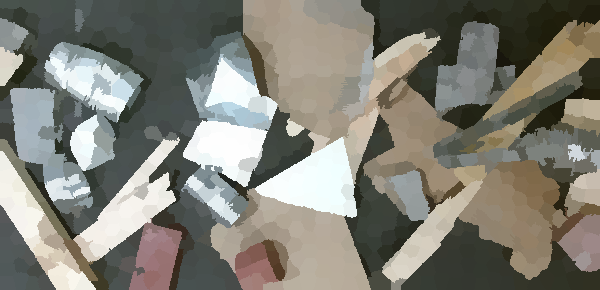

In [8]:
nr, nc = size(imlab)
seeds = adjusted_grid(hexgrid(nr, nc, k), depgrad+labgrad)

# Do superpixel segmentation
sp_labels, nsp = slic(imlab, seeds, k, m, niter=5)
sp_centroids = cluster_centroids(sp_labels, nsp)

# Mean color values over superpixels
lab_means, color_superpix = color_means(imlab, sp_labels, nsp)
convert(Image{Color.RGB}, color_superpix)

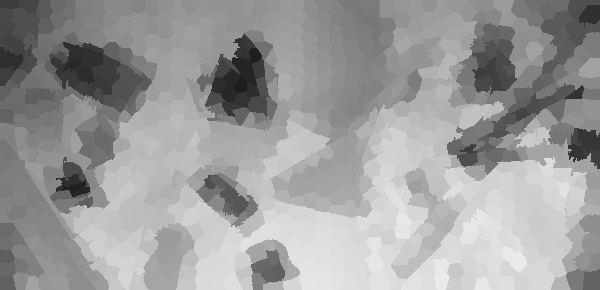

In [9]:
dep_means, depth_superpix = color_means(dep, sp_labels, nsp)
grayim(depth_superpix)

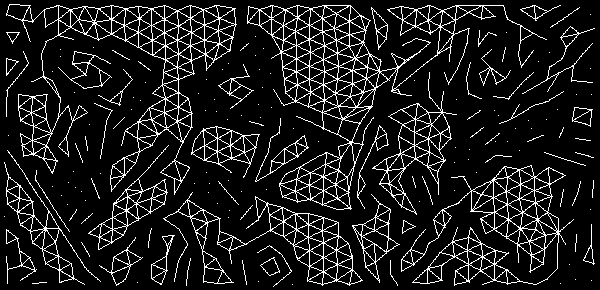

In [10]:
# Compute a regional adjacency graph from superpixels, then cut it
graph, edgewts, borders = 
adjacency_graph(sp_labels, nsp, lab_means, dep_means, depth_weight=0.5)
graph = cut_graph(graph, edgewts, 0.07)

# Make an image of the graph
graph_edges = graph_image(graph, sp_centroids, nr, nc)
grayim(graph_edges)

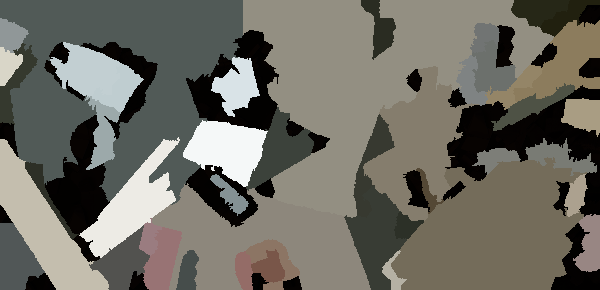

In [11]:
# Combine superpixels according to the cut adjacency graph
seg_labels, nsegments = merged_superpixels(sp_labels, graph)

# Make an image of colored segment patches
seg_lab_means, color_segments = color_means(imlab, seg_labels, nsegments)
convert(Image{Color.RGB}, color_segments)

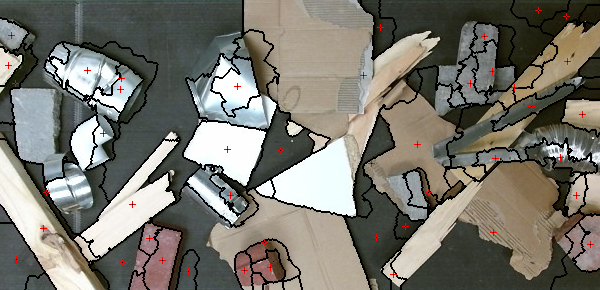

In [12]:
# Overlay segment boundaries on (a copy of) the input color image
seg_img = segment_overlay(seg_labels, imlab, color_segments, cluster_centroids(seg_labels, nsegments))
convert(Image{Color.RGB}, seg_img)

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.07,"t",0.07,0.0:0.01:0.15)

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.5,"w",0.5,0.0:0.05:1.0)

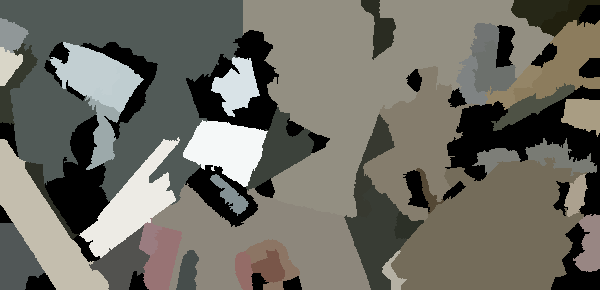

In [13]:
# Recombine superpixels into segments
# - t is the RAG edge weight threshold
# - w is the node-to-node depth distance weighting in 0-1 (color weighting is 1-w)
# - gw is the weighting of depth gradients relative to color+depth distance information

# @manipulate for t = 0.0:0.01:1.0, w = 0.0:0.05:1.0, gw = 0.0:0.01:1.0
@manipulate for t = 0.0:0.01:0.15, w = 0.0:0.05:1.0
    # Compute a regional adjacency graph from superpixels, then cut it
    graph, edgewts, borders = 
    adjacency_graph(sp_labels, nsp, lab_means, dep_means, depth_weight=w)
    graph = cut_graph(graph, edgewts, t)
    seg_labels, nsegments = merged_superpixels(sp_labels, graph)
    
    # Experimental: include integrated gradient magnitude in graph edge weight
    #     gradwts = grad_weights(graph, centroids, depgrad)
    #     g = cut_graph(graph, (1-gw)*edgewts + gw*gradwts, t)

    seg_lab_means, color_segments = color_means(imlab, seg_labels, nsegments)
#     seg_borders = segment_borders(seg_labels, color_segments)
    
    convert(Image{Color.RGB}, color_segments)
end

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.07,"t",0.07,0.0:0.01:0.15)

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.5,"w",0.5,0.0:0.05:1.0)

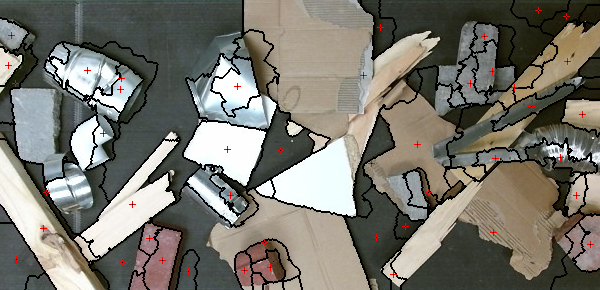

In [14]:
@manipulate for t = 0.0:0.01:0.15, w = 0.0:0.05:1.0
    # Compute a regional adjacency graph from superpixels, then cut it
    graph, edgewts, borders = 
    adjacency_graph(sp_labels, nsp, lab_means, dep_means, depth_weight=w)
    graph = cut_graph(graph, edgewts, t)
    seg_labels, nsegments = merged_superpixels(sp_labels, graph)
    
    # Overlay segment boundaries on (a copy of) the input color image
    seg_img = segment_overlay(seg_labels, imlab, color_segments, cluster_centroids(seg_labels, nsegments))
    
    convert(Image{Color.RGB}, seg_img)
end